In [1]:
import scipy.signal;
import scipy.sparse as spr;
import numpy as np;
import matplotlib.pyplot as plt;
from matplotlib import animation;
%matplotlib inline
from RBComb.Helper.FunctionInterpolator import *

In [2]:
plt.rcParams['figure.figsize'] = [6, 6]

In [3]:
class LatticeSite:
    def __init__(self, physicalLocation):
        self.physicalLocation = physicalLocation;
        self.matrixIndex = -1;
        self.enabled = True;
        self.siteConnections = [];
        
    def prune(self, physicalMin, physicalMax):
        if self.physicalLocation[0] < physicalMin[0]:
            self.enabled = False;
        if self.physicalLocation[0] > physicalMax[0]:
            self.enabled = False;
        if self.physicalLocation[1] < physicalMin[1]:
            self.enabled = False;
        if self.physicalLocation[1] > physicalMax[1]:
            self.enabled = False;
        
    def setIndex(self, currentIndex):
        if self.enabled:
            self.matrixIndex = currentIndex;
            currentIndex = currentIndex + 1;
        return currentIndex;
    
    def setLink(self, partner):
        if self.enabled and partner.enabled:
            self.siteConnections.append(partner);
            partner.siteConnections.append(self);
            return 1;
        return 0;

In [4]:
class UnitCell:
    def __init__(self, location, offset):
        self.siteA = LatticeSite(location);
        self.siteB = LatticeSite(location+offset);
        
    def prune(self,physicalMin, physicalMax):
        self.siteA.prune(physicalMin, physicalMax);
        self.siteB.prune(physicalMin, physicalMax);
    
    def setIndices(self, currentIndex):
        currentIndex = self.siteA.setIndex(currentIndex);
        currentIndex = self.siteB.setIndex(currentIndex);
        return currentIndex;

In [5]:
class BraidingAction:
    def __init__(self, centerLocation, startAngle, endAngle, windingRadius, duration):
        self.centerLocation = centerLocation;
        self.windingRadius = windingRadius;
        self.startAngle = startAngle;
        self.endAngle = endAngle;
        self.duration = duration;    
    def getPhysicalLocation(self, currentTime):
        windingAngle = self.startAngle+(currentTime-self.startTime)*(self.endAngle-self.startAngle)/self.duration;
        return self.centerLocation+self.windingRadius*np.array([np.cos(windingAngle),np.sin(windingAngle)]);

In [6]:
class Vortex:
    def __init__(self, l0, alpha):
        self.l0 = l0;
        self.alpha = alpha; 
        self.braidingSequence = [];
        self.endTime = 0;
        self.lastPosition = np.array([0,0]);
        
    def addBraidingAction(self, braidingAction):
        braidingAction.startTime = self.endTime;
        self.endTime += braidingAction.duration;
        braidingAction.endTime = self.endTime;
        self.braidingSequence.append(braidingAction);
        
    def getPhysicalLocation(self, currentTime):
        for braidingAction in self.braidingSequence:
            if braidingAction.startTime <= currentTime and braidingAction.endTime >= currentTime:
                self.lastPosition = braidingAction.getPhysicalLocation(currentTime);
                break;
        return self.lastPosition;

In [7]:
# Lattice configuration
physicalStartingPoint = [0.01,0.6]
physicalEndPoint = [63.5,47.5]

siteStartingPoint = [0,-40];
siteEndingPoint = [64,48];

latticeParameter = 1.0;

_s1 = latticeParameter*np.array([0,-1.0]);
_s2 = latticeParameter*0.5*np.array([np.sqrt(3.0),1.0]);
_s3 = latticeParameter*0.5*np.array([-np.sqrt(3.0),1.0]);

_kPrefact = 4.0*np.pi/(3.0*np.sqrt(3.0)*latticeParameter);
_kPlus = _kPrefact*np.array([1,0])
_kMinus = _kPrefact*np.array([-1,0])
_kPM = _kPlus-_kMinus;

vectorU = _s2-_s1;
vectorV = _s2-_s3;
siteOffset = _s2;

# Local properties
localFrequency = 25e3;
localMass = 2328*(1e-6)*(np.pi*((250e-6)**2));
localStiffness = localMass*((2.0*np.pi*localFrequency)**2);
Q = 30000;
dampingTau = (2.0*np.pi*localFrequency/Q);
maxEigenvalue = (localFrequency*2*np.pi*1.1)**2;

# Coupling terms
couplingStiffness = localStiffness*0.2;
baseStiffness = couplingStiffness*0.1;

#self, centerLocation, startAngle, endAngle, duration)

# Vortices
Vortices = [];

vortex1 = Vortex(l0=5, alpha=1);
Vortices.append(vortex1)

vortex2 = Vortex(l0=5, alpha=1);
Vortices.append(vortex2)

vortex3 = Vortex(l0=5, alpha=1);
Vortices.append(vortex3)

# Centers for braiding
leftCenter=np.array([21.0,24])
rightCenter=np.array([42.0,24])

# Non-abelian braiding sequence. Part A
t0 = 0.008;
# Non-abelian braiding sequence. Part A
def performBraidingSequenceB2B1():
    # T1 (1,2,3) -> (2,1,3)
    vortex1.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=np.pi, endAngle=0, windingRadius = 10.5, duration=t0));
    vortex2.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=0, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    vortex3.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=0, endAngle=0, windingRadius = 10.5, duration=t0));
    
    # T2 (2,1,3) -> (2,3,1)
    vortex2.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=-np.pi, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    vortex1.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=np.pi, endAngle=0, windingRadius = 10.5, duration=t0));
    vortex3.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=0, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    
    # T3 (2,3,1) -> (3,2,1)
    vortex2.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=-np.pi, endAngle=0, windingRadius = 10.5, duration=t0));
    vortex3.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=0, endAngle=np.pi, windingRadius = 10.5, duration=t0));
    vortex1.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=0, endAngle=0, windingRadius = 10.5, duration=t0));
   
    # T4 (3,2,1) -> (3,1,2)
    vortex3.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=-np.pi, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    vortex2.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=np.pi, endAngle=0, windingRadius = 10.5, duration=t0));
    vortex1.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=0, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    
    # T5 (3,1,2) -> (1,3,2)
    vortex3.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=-np.pi, endAngle=0, windingRadius = 10.5, duration=t0));
    vortex1.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=0, endAngle=np.pi, windingRadius = 10.5, duration=t0));
    vortex2.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=0, endAngle=0, windingRadius = 10.5, duration=t0));
   
    # T6 (1,3,2) -> (1,2,3)
    vortex1.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=-np.pi, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    vortex3.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=np.pi, endAngle=0, windingRadius = 10.5, duration=t0));
    vortex2.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=0, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    

def performBraidingSequenceB1B2():
    # T1 (1,2,3) -> (2,1,3)
    vortex1.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=-np.pi, endAngle=0, windingRadius = 10.5, duration=t0));
    vortex2.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=0, endAngle=np.pi, windingRadius = 10.5, duration=t0));
    vortex3.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=0, endAngle=0, windingRadius = 10.5, duration=t0));
    
    # T2 (2,1,3) -> (2,3,1)
    vortex2.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=-np.pi, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    vortex1.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=np.pi, endAngle=0, windingRadius = 10.5, duration=t0));
    vortex3.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=0, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    
    # T3 (2,3,1) -> (3,2,1)
    vortex2.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=-np.pi, endAngle=0, windingRadius = 10.5, duration=t0));
    vortex3.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=0, endAngle=np.pi, windingRadius = 10.5, duration=t0));
    vortex1.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=0, endAngle=0, windingRadius = 10.5, duration=t0));
    
    # T4 (3,2,1) -> (3,1,2)
    vortex3.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=-np.pi, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    vortex2.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=np.pi, endAngle=0, windingRadius = 10.5, duration=t0));
    vortex1.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=0, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    
    # T5 (3,1,2) -> (1,3,2)
    vortex3.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=np.pi, endAngle=0, windingRadius = 10.5, duration=t0));
    vortex1.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=0, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    vortex2.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=0, endAngle=0, windingRadius = 10.5, duration=t0));
    
    # T6 (1,3,2) -> (1,2,3)
    vortex1.addBraidingAction(BraidingAction(centerLocation=leftCenter, startAngle=-np.pi, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
    vortex3.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=np.pi, endAngle=0, windingRadius = 10.5, duration=t0));
    vortex2.addBraidingAction(BraidingAction(centerLocation=rightCenter, startAngle=0, endAngle=-np.pi, windingRadius = 10.5, duration=t0));
# Select here the braiding order
#performBraidingSequenceB1B2();
performBraidingSequenceB2B1();

Delta0 = 1;

In [8]:
print(localStiffness)
print(couplingStiffness)
print(baseStiffness)

11.2785331425
2.25570662849
0.225570662849


In [9]:
# Create lattice
Sample = {};
numberOfSites = 0;
for i in range(siteStartingPoint[0],siteEndingPoint[0]):
    for j in range(siteStartingPoint[1],siteEndingPoint[1]):
        newUnit = UnitCell(vectorU*i + vectorV*j, siteOffset);
        newUnit.prune(physicalStartingPoint,physicalEndPoint);
        numberOfSites = newUnit.setIndices(numberOfSites);
        newUnit.siteA.setLink(newUnit.siteB);
        if newUnit.siteA.enabled or newUnit.siteB.enabled:
            Sample[(i,j)] = newUnit;

In [10]:
# Establish links between unit cells
for i in range(siteStartingPoint[0],siteEndingPoint[0]):
    for j in range(siteStartingPoint[1],siteEndingPoint[1]):
        if (i,j) in Sample:
            
            _xTemp = Sample[(i,j)].siteA.physicalLocation[0]
            _yTemp = Sample[(i,j)].siteA.physicalLocation[1]

            
            if(i+1,j) in Sample:
                Sample[(i,j)].siteB.setLink(Sample[(i+1,j)].siteA)
            if(i,j+1) in Sample:
                Sample[(i,j)].siteB.setLink(Sample[(i,j+1)].siteA)

In [11]:
# We want here all the A sites at the edge (top + bottom)
edgeAcoor = []
for y in range(-15,22):
    coordinate = (31,y)
    edgeAcoor.append(coordinate)
for y in range(-14,22):
    coordinate = (30,y)
    edgeAcoor.append(coordinate)
for y in range(0,37):
    coordinate = (1,y)
    edgeAcoor.append(coordinate)
for y in range(-1,36):
    coordinate = (2,y)
    edgeAcoor.append(coordinate)
    
#print(edgeAcoor)

In [12]:
# Now we add left and right
for i in range(siteStartingPoint[0],siteEndingPoint[0]):
    for j in range(siteStartingPoint[1],siteEndingPoint[1]):
        if (i,j) in Sample:
            
            _xTemp = Sample[(i,j)].siteA.physicalLocation[0]
            _yTemp = Sample[(i,j)].siteA.physicalLocation[1]
            if _xTemp > 62:
                edgeAcoor.append((i,j))
            if _xTemp < 3:
                 edgeAcoor.append((i,j))
#print(edgeAcoor)

In [13]:
# Count links
numLinks = 0;
for unitCellID in Sample:
    unitCell = Sample[unitCellID]
    for link in unitCell.siteA.siteConnections:
        numLinks += 1;

In [14]:
# Assemble distance matrices for force calculation

# Stiffness matrix (only half, and no diagonal)
_kVec = np.zeros(numLinks,dtype=float);

# Site locations
_rVec_X = np.zeros(numLinks,dtype=float);
_rVec_Y = np.zeros(numLinks,dtype=float);

# Bond distances
_sVec_X = np.zeros(numLinks,dtype=float);
_sVec_Y = np.zeros(numLinks,dtype=float);

# Vector indices
_iVec = np.zeros(numLinks,dtype=int);
_jVec = np.zeros(numLinks,dtype=int);

# Intermediate vectors for stiffness computation
_vOnes = np.ones(numLinks,dtype=float);
_intm1 = np.zeros(numLinks,dtype=complex);
_intm2 = np.zeros(numLinks,dtype=float);
_intm3 = np.zeros(numLinks,dtype=float);

diagonalElements = (localStiffness/localMass)*np.ones((numberOfSites));
diagonalIndices = np.arange(0,numberOfSites,dtype=int)

currentLink = 0;
for unitCellID in Sample:
    unitCell = Sample[unitCellID];
    for link in unitCell.siteA.siteConnections:
        _rVec_X[currentLink] = unitCell.siteA.physicalLocation[0];
        _rVec_Y[currentLink] = unitCell.siteA.physicalLocation[1];
        _sVec_X[currentLink] = link.physicalLocation[0] - unitCell.siteA.physicalLocation[0];
        _sVec_Y[currentLink] = link.physicalLocation[1] - unitCell.siteA.physicalLocation[1];
        _iVec[currentLink] = unitCell.siteA.matrixIndex;
        _jVec[currentLink] = link.matrixIndex;
        currentLink += 1;

In [67]:
# Generate diagonal elements
disorder = 0.005
diagonalElements = (localStiffness/localMass)*((1-disorder/2)*np.ones((numberOfSites))+disorder*np.random.rand(numberOfSites));
for edgeAsite in edgeAcoor:
    # First we find the A-site matrix indicies
    matIndexA = Sample[edgeAsite].siteA.matrixIndex
    # Here we change the diagonal elements of the A-sites (again you can choose with or without disorder)
    diagonalElements[matIndexA] = (localStiffness/localMass)*((1-disorder/2)+disorder*np.random.rand(numberOfSites)[0]) + 1.1*(1)*(couplingStiffness*0.5/localMass)
    # kMatrix[matIndexA, matIndexA] = (localStiffness/localMass) + 1.1*(couplingStiffness*0.5/localMass)
    
    # Now we loop over all connections of that A-site (which is the B-sites at the edge)
    for link in Sample[edgeAsite].siteA.siteConnections:
        matIndexB = link.matrixIndex
        # Here we change the diagonal elements of the B-sites
        diagonalElements[matIndexB] = (localStiffness/localMass)*((1-disorder/2)+disorder*np.random.rand(numberOfSites)[0]) - 1.1*(1)*(couplingStiffness*0.5/localMass)
        # kMatrix[matIndexB, matIndexB] = (localStiffness/localMass)*1 - 1.1*(couplingStiffness*0.5/localMass)

In [68]:
def updateDynamicalMatrix(currentTime):
    # Convert to time steps

    # This function creates the dynamical matrix for the system at time T
    # Compute vortex product Delta
    _intm1 = Delta0*_vOnes;
    for vortex in Vortices:
        vortexCoordinates = vortex.getPhysicalLocation(currentTime);
        _intm2 = _rVec_X - vortexCoordinates[0];
        _intm3 = _rVec_Y - vortexCoordinates[1];
        _intm1 = _intm1*np.tanh(np.sqrt(_intm2**2+_intm3**2)/vortex.l0)*np.exp(1j*(vortex.alpha-np.arctan2(_intm3,_intm2)))

    # Compute coupling stiffness
    _kVec = (baseStiffness/localMass) + (couplingStiffness*0.5/localMass)*(1.0+np.real(_intm1*np.exp(1j*(_kPlus[0]*_sVec_X+_kPlus[1]*_sVec_Y+_kPM[0]*_rVec_X+_kPM[1]*_rVec_Y))))

    kMatrix = spr.csr_matrix((np.concatenate((_kVec,_kVec,diagonalElements)),(np.concatenate((_iVec,_jVec,diagonalIndices)), np.concatenate((_jVec,_iVec,diagonalIndices)))), shape=(numberOfSites, numberOfSites));

    #we add disorder in localStiffness
    #to disregard disorder use the outcommented kMatrix instead
    kMatrix.setdiag(diagonalElements);
    #kMatrix.setdiag((localStiffness/localMass)*(np.ones((numberOfSites))));
    return kMatrix;

In [76]:
def getKVec(currentTime):
    # This function creates the dynamical matrix for the system at time T
    # Compute vortex product Delta
    timeStep = 1/(140e3);
    currentTimeSteps = currentTime/timeStep;
    
    # The next line is for simulating the time steps. Comment it out when calculating interpolation params.
    # currentTime = np.floor(currentTimeSteps)*timeStep;
    
    _intm1 = Delta0*_vOnes;
    for vortex in Vortices:
        vortexCoordinates = vortex.getPhysicalLocation(currentTime);
        _intm2 = _rVec_X - vortexCoordinates[0];
        _intm3 = _rVec_Y - vortexCoordinates[1];
        _intm1 = _intm1*np.tanh(np.sqrt(_intm2**2+_intm3**2)/vortex.l0)*np.exp(1j*(vortex.alpha-np.arctan2(_intm3,_intm2)))

    # Compute coupling stiffness
    return (baseStiffness/localMass) + (couplingStiffness*0.5/localMass)*(1.0+np.real(_intm1*np.exp(1j*(_kPlus[0]*_sVec_X+_kPlus[1]*_sVec_Y+_kPM[0]*_rVec_X+_kPM[1]*_rVec_Y))))

In [77]:
def getMultivec(times):
    element = 1840;
    results = np.zeros([len(times)], dtype = 'float');
    for i in range(len(times)):
        results[i] = getKVec(times[i])[element];
    return results;

In [81]:
time = np.linspace(0,1,5000)

In [82]:
stiffness = functionToInterpolate(time)

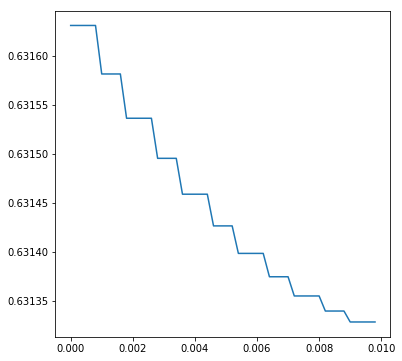

In [83]:
plt.plot(time[0:50], stiffness[0:50])

In [78]:
functionToInterpolate = lambda x: getMultivec(x*0.008)*0.15/(baseStiffness/localMass);

In [22]:
interpolator = FunctionInterpolator()

In [23]:
coeffs = interpolator.performInterpolation(functionToInterpolate)

In [38]:
np.save('coefficients_A.npy', coeffs)

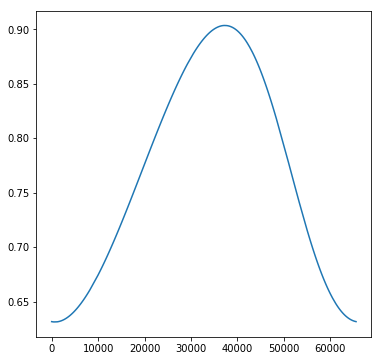

In [27]:
p = interpolator.performValidation((coeffs))
plt.plot(np.array(p, dtype='float')/interpolator.yScaling)

In [28]:
np.save('coefficients_A.npy', coeffs)

In [ ]:
def getMultivec2(times):
    element = 1840;
    results = np.zeros([len(times)], dtype = 'float');
    for i in range(len(times)):
        results[i] = getKVec(times[i])[element];
    return results;

In [33]:
functionToInterpolate2 = lambda x: getMultivec(x*0.008+0.008)*0.15/(baseStiffness/localMass);

In [34]:
coeffs2 = interpolator.performInterpolation(functionToInterpolate2)

In [37]:
np.save('coefficients_B.npy', coeffs2)

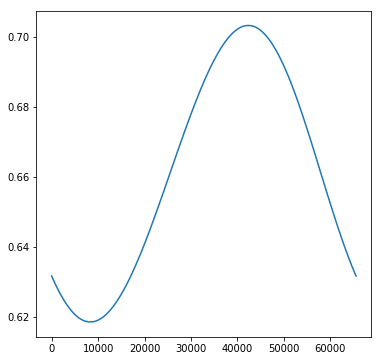

In [35]:
p2 = interpolator.performValidation((coeffs2))
plt.plot(np.array(p2, dtype='float')/interpolator.yScaling)